## Goal: timeseries plots of DJF-mean SST and Chl
___
#### Secondary Goal: how does each step in your workflow result in a dimension reduction?

In [1]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

#### Read in an ensemble member from the CESM-LE

In [14]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variables = ['SST', 'diatChl', 'spChl', 'diazChl']
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

# loop over variables, construct list of datasets
ds_list = []
for v in variables:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            data_vars=[v],
                            chunks={'nlon': 16})
    # SST has a singleton z_t dimension, so remove this to avoid problems on merge
    if v == 'SST':
        dsi = dsi.squeeze(dim='z_t', drop=True).drop('dz')
        
        
    ds_list.append(dsi)
    
ds = xr.merge(ds_list)
ds = ds[variables+grid_vars]

ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                         calendar=ds.time.calendar), dims=('time'))

ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

variables = list(filter(lambda v: 'Chl' not in v, variables)) + ['Chl_surf']
ds = ds[variables+grid_vars]
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1872, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1872, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1872, 2), meta=np.ndarray>

#### Reduce data set to a date range and the southern ocean:

In [15]:
## Clip to 1920 - end:
ds = ds[variables+grid_vars].isel(time=slice(840, 1872))
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1032, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1032, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1032, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(1032, 2), meta=np.ndarray>

In [16]:
# Clip to Southern Ocean:
ds_so = ds[variables+grid_vars].where((ds.TLAT <= -45) & (ds.KMT > 0))
ds_so

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1032, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    SST         (time, nlat, nlon) float32 dask.array<chunksize=(1032, 384, 16), meta=np.ndarray>
    Chl_surf    (time, nlat, nlon) float32 dask.array<chunksize=(1032, 384, 16), meta=np.ndarray>
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 16), meta=np.ndarray>
    dz          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 16), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) float64 dask.array<chunksize=(1032, 2, 384, 16), meta=np.ndarray>

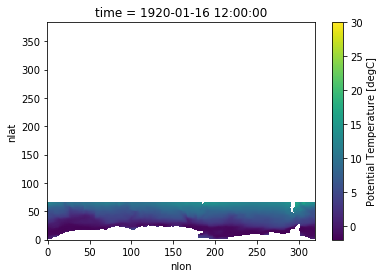

In [17]:
# Test (this takes a minute):
ds_so.SST.isel(time=0).plot(vmin=-2, vmax=30)

### Create timeseries of DJF means
using `xarray.Dataset.resample`

indexer ({dim: freq}, optional) – Mapping from the dimension name to resample frequency [1]. The dimension must be datetime-like.

In [ ]:
test = ds_so.resample(time="QS-DEC").mean()

In [26]:
sst_rs = ds_so.SST.resample(time="QS-DEC").mean()
sst_rs

<xarray.DataArray 'SST' (time: 345, nlat: 384, nlon: 320)>
dask.array<stack, shape=(345, 384, 320), dtype=float32, chunksize=(1, 384, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1919-12-01 00:00:00 ... 2005-12-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [25]:
chl_rs = ds_so.Chl_surf.resample(time="QS-DEC").mean()
chl_rs

<xarray.DataArray 'Chl_surf' (time: 345, nlat: 384, nlon: 320)>
dask.array<stack, shape=(345, 384, 320), dtype=float32, chunksize=(1, 384, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1919-12-01 00:00:00 ... 2005-12-01 00:00:00
Dimensions without coordinates: nlat, nlon

I've lost TAREA with this.. does that matter? 

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import pop_tools
from statistics import mean
from matplotlib import style
from scipy import stats

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

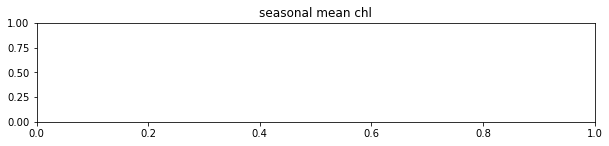

In [29]:
# Plot all Basins
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(211)
ax1.set_title('seasonal mean chl')
ax1.plot(chl_rs['time'].values, chl_rs.values, color = 'purple')
plt.gca()

ax2 = fig.add_subplot(212)
ax2.set_title('seasonal mean SST')
ax2.plot(sst_rs['time'].values, sst_rs.values, color = 'skyblue')
plt.gca()
